In [1]:
import cv2 as cv

In [4]:
img.shape

(873, 1164, 3)

In [6]:
img = cv.imread('data\\sech_2\\2024.04.05\\Image28.jpg')
img_crop = img[100:808, 40:1030]
cv.imshow('ghjh', img)
cv.waitKey(0)
cv.destroyAllWindows()

In [6]:
img_crop.shape

(708, 990, 3)

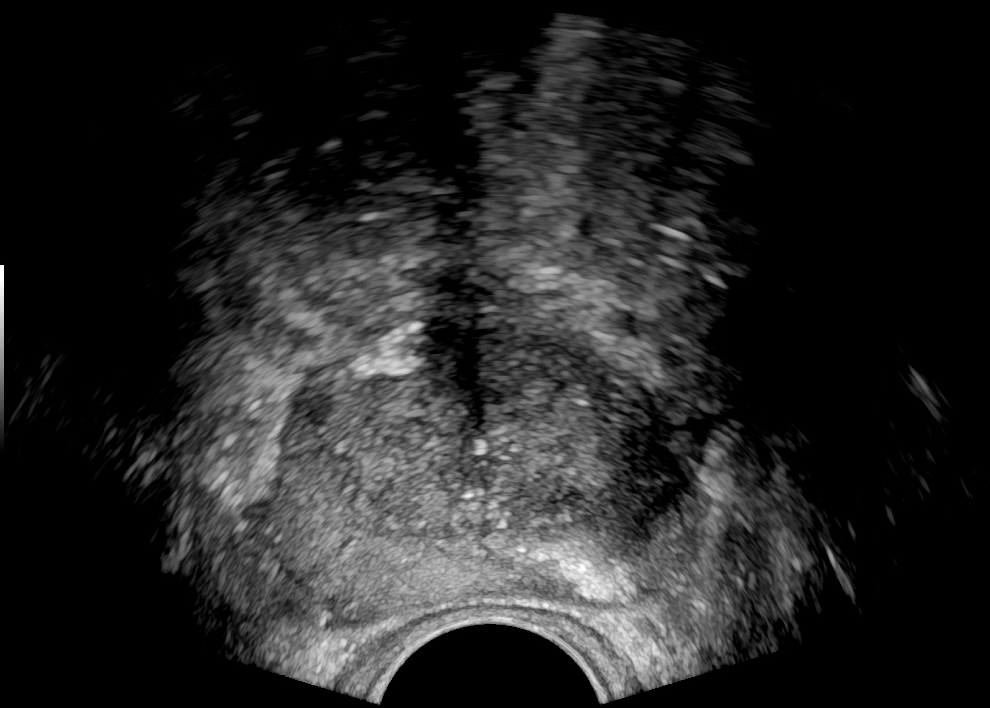

In [12]:
color = (0, 0, 0)  # Цвет в формате BGR (чёрный)
thickness = -1  # Толщина -1 означает закрашенный прямоугольник
cv.rectangle(img_crop, (0, 675), (284, 708), color, thickness)
cv2_imshow(img_crop)

# SAM

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Параметры
# image_path = "Image53.jpg"  # Укажите путь к изображению
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Загрузите вес SAM модели
model_type = "vit_h"  # Тип модели: vit_h, vit_l, vit_b

# Загружаем модель SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Перенос модели на GPU
sam.to("cuda")  # Использование GPU, если доступно

# Создаем генератор масок
mask_generator = SamAutomaticMaskGenerator(sam)

# Читаем изображение
# image = cv2.imread(image_path)
image = img_crop
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертируем BGR в RGB для SAM

# Генерируем маски
masks = mask_generator.generate(image)

# Визуализируем маски
def overlay_masks(image, masks):
    overlay = image.copy()
    for mask in masks:
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        overlay[mask['segmentation']] = overlay[mask['segmentation']] * 0.5 + color * 0.5
    return overlay

# Отображение изображения с сегментами
segmented_image = overlay_masks(image, masks)
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'torch'

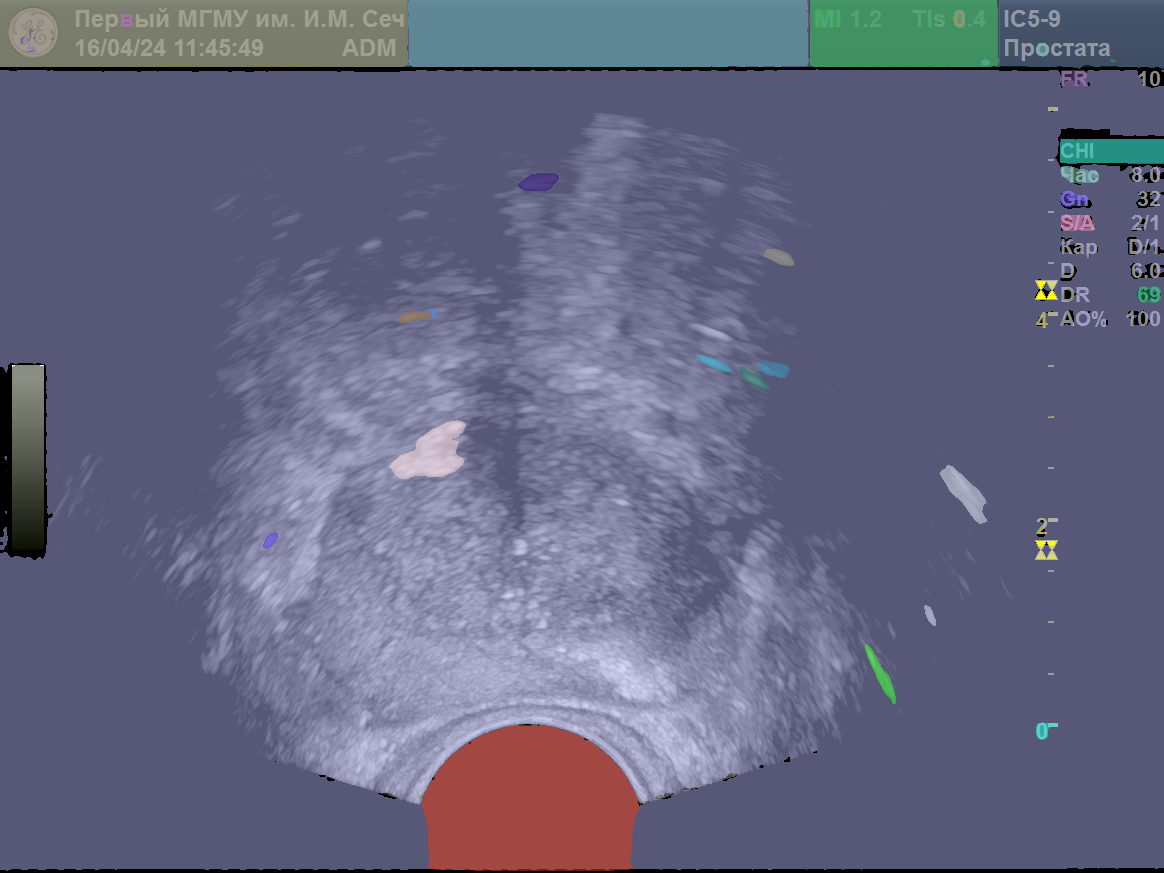

In [14]:
masks = mask_generator.generate(img)

# Визуализируем маски
def overlay_masks(image, masks):
    overlay = image.copy()
    for mask in masks:
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        overlay[mask['segmentation']] = overlay[mask['segmentation']] * 0.5 + color * 0.5
    return overlay

# Отображение изображения с сегментами
segmented_image = overlay_masks(img, masks)
cv2_imshow(segmented_image)